
# All-Features Threshold Pruner: Recall vs. Pruning

This notebook tests a **high-recall candidate generator**:

> Candidate if two windows share **at least `t_shared` features** among all (neuron,bin) features.

**Why this works here:** In i.i.d. synthetic data, "rare" features don't exist, so rare-feature pruning can miss motifs. A direct **intersection threshold** is recall-friendly and still prunes hard when `t_shared` is high (e.g., 7).

**Metrics:** Pair recall at pruning/after significance (hypergeometric + BH-FDR), window support, and candidate fraction.

Defaults: `W=500, N=100, B=30, p=0.03, m=5, R=20, t_shared=7`.


t_shared >= 6:
  Pair recall @prune = 0.890 (95% CI 0.839-0.926)
  Pair recall @sig   = 0.005 (95% CI 0.001-0.028)
  Candidate fraction = 0.0564 ± 0.0019
t_shared >= 7:
  Pair recall @prune = 0.725 (95% CI 0.659-0.782)
  Pair recall @sig   = 0.690 (95% CI 0.623-0.750)
  Candidate fraction = 0.0205 ± 0.0005


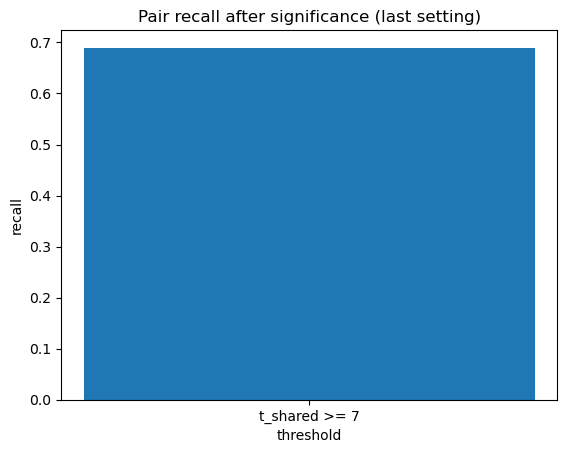

In [1]:

import numpy as np
import matplotlib.pyplot as plt
import math
from collections import defaultdict
import pandas as pd

# Helpers
def wilson_ci(k, n, z=1.96):
    if n == 0: return (0.0, 0.0)
    p = k / n
    denom = 1 + z**2 / n
    center = (p + z**2/(2*n)) / denom
    half = z * math.sqrt((p*(1-p) + z**2/(4*n)) / n) / denom
    return max(0.0, center - half), min(1.0, center + half)

def build_logfac(M):
    logfac = np.zeros(M+1, dtype=float)
    for x in range(2, M+1):
        logfac[x] = logfac[x-1] + math.log(x)
    return logfac

def log_comb(logfac, n, k):
    if k < 0 or k > n: return -1e300
    return logfac[n] - logfac[k] - logfac[n-k]

def hypergeom_sf(logfac, M, K, n, x):
    hi = min(K, n)
    s = 0.0
    for t in range(x, hi+1):
        s += math.exp(log_comb(logfac, K, t) + log_comb(logfac, M-K, n-t) - log_comb(logfac, M, n))
    return min(1.0, max(0.0, s))

def fdr_bh(pvals, q=0.05):
    m = len(pvals)
    if m == 0:
        return np.array([], dtype=bool), np.array([])
    order = np.argsort(pvals)
    ranked = pvals[order]
    crit = q * (np.arange(1, m+1) / m)
    below = ranked <= crit
    if not np.any(below):
        rejs = np.zeros(m, dtype=bool)
    else:
        kmax = np.max(np.where(below)[0])
        thresh = ranked[kmax]
        rejs = pvals <= thresh
    qvals = np.empty(m, dtype=float)
    prev = 1.0
    for idx in range(m-1, -1, -1):
        qval = min(prev, m / (idx+1) * ranked[idx])
        qvals[order[idx]] = qval
        prev = qval
    return rejs, qvals

# Data params
SEED = 13579
rng = np.random.default_rng(SEED)
W,N,B = 500,100,30
p = 0.03
M = N*B
logfac = build_logfac(M)
m_motif = 5
remove_before_embed = 5
q_fdr = 0.05

motif_coords = [(5,3), (12,7), (47,15), (63,19), (88,26)]

def allfeat_candidates(flat, t_shared):
    # Inverted index on all features, then filter by intersection >= t_shared
    inv = defaultdict(list)
    W = flat.shape[0]
    for i in range(W):
        feats = np.where(flat[i])[0]
        for f in feats:
            inv[f].append(i)
    cand_pairs = set()
    for f, idxs in inv.items():
        L = len(idxs)
        if L < 2: continue
        for a in range(L):
            i = idxs[a]
            for c in range(a+1, L):
                j = idxs[c]
                if i<j: cand_pairs.add((i,j))
                else:    cand_pairs.add((j,i))
    # filter by actual intersection
    filtered = set()
    for (i,j) in cand_pairs:
        if int(np.logical_and(flat[i], flat[j]).sum()) >= t_shared:
            filtered.add((i,j))
    return filtered

def replicate_once(t_shared):
    windows = (rng.random((W,N,B)) < p)
    motif_idxs = rng.choice(W, size=m_motif, replace=False)
    # remove then embed
    for w in motif_idxs:
        ys, xs = np.where(windows[w])
        total = len(ys)
        if total > 0:
            k_eff = min(remove_before_embed, total)
            idx = rng.choice(total, size=k_eff, replace=False)
            windows[w, ys[idx], xs[idx]] = False
        for (j,b) in motif_coords:
            windows[w, j, b] = True
    flat = windows.reshape(W, -1)
    cand_pairs = allfeat_candidates(flat, t_shared)
    motif_pairs = set()
    for i in range(m_motif):
        for j in range(i+1, m_motif):
            a = motif_idxs[i]; b = motif_idxs[j]
            motif_pairs.add((min(a,b), max(a,b)))
    kp_prune = sum(1 for e in motif_pairs if e in cand_pairs)
    # significance
    pvals, pairs = [], []
    for (a,b) in cand_pairs:
        Ka = int(flat[a].sum()); Kb = int(flat[b].sum())
        x = int(np.logical_and(flat[a], flat[b]).sum())
        pvals.append(hypergeom_sf(logfac, M, Ka, Kb, x)); pairs.append((a,b))
    pvals = np.array(pvals)
    rejs, _ = fdr_bh(pvals, q=q_fdr)
    sig_pairs = [pairs[i] for i,f in enumerate(rejs) if f]
    kp_sig = sum(1 for e in motif_pairs if e in set(sig_pairs))
    cand_frac = len(cand_pairs)/(W*(W-1)//2)
    return kp_prune, kp_sig, cand_frac

# Run
R = 20
for t_shared in [6,7]:
    total_pairs = R * (m_motif*(m_motif-1)//2)
    Kp = 0; Ks = 0; fracs = []
    for _ in range(R):
        kp, ks, cf = replicate_once(t_shared)
        Kp += kp; Ks += ks; fracs.append(cf)
    pr_lo, pr_hi = wilson_ci(Kp, total_pairs); ps_lo, ps_hi = wilson_ci(Ks, total_pairs)
    print(f"t_shared >= {t_shared}:")
    print(f"  Pair recall @prune = {Kp/total_pairs:.3f} (95% CI {pr_lo:.3f}-{pr_hi:.3f})")
    print(f"  Pair recall @sig   = {Ks/total_pairs:.3f} (95% CI {ps_lo:.3f}-{ps_hi:.3f})")
    print(f"  Candidate fraction = {np.mean(fracs):.4f} ± {np.std(fracs):.4f}")

# Simple bar chart for recall@sig across thresholds
vals = [Ks/total_pairs]  # from last t_shared run
plt.figure()
plt.bar([0], vals)
plt.xticks([0], [f"t_shared >= {t_shared}"])
plt.title("Pair recall after significance (last setting)")
plt.xlabel("threshold")
plt.ylabel("recall")
plt.show()
